In [98]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime, date, timedelta

# statistical analysis
import statsmodels.api as sm
from statsmodels import regression

import yfinance as yfin
yfin.pdr_override()

import matplotlib.pyplot as plt
import seaborn as sns

#from var import VaR

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

# Assignment
Familiarity with several pricing models and how to apply them to a portfolio. Now calculate the VWAP, Sharpe and Alpha for your portfolio from the start of the semester  to the date of you calculations. Your calculation results and the VaR calculations that you performed last week are the main content of the Portfolio Review presentation that is next week's subject and assignment. -- Remember Presentation is Important

# Variables

In [99]:
start_date = datetime(2022, 1, 1)
end_date = datetime.now()
alpha = 0.05
period = '5y'

# Functions

# Load Data

## Load Variables

In [100]:
var_lst = ['^TNX']
data = pdr.get_data_yahoo(var_lst, period=period)['Close']
rf_rate = round((data.mean() / 100),4)
rf_rate

[*********************100%%**********************]  1 of 1 completed


0.0221

In [101]:
var_lst = ['SPY']
bench_df = pdr.get_data_yahoo(var_lst, period=period)['Close']
#bench_df = round((bench_df.mean() / 100),4)
bench_df = pd.DataFrame(bench_df)
bench_df.columns = ['SPY']
benchPercent_df = bench_df.pct_change()[1:]
benchPercent_df.head()

[*********************100%%**********************]  1 of 1 completed


,SPY
Date,
2018-10-09,-0.0015
2018-10-10,-0.0317
2018-10-11,-0.0220
2018-10-12,0.0139
2018-10-15,-0.0056


## Load Portfolio

In [102]:
folio_df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w6/data/DATA618_Portfolio.csv', 
                 dtype={
                    'ID': 'int',
                    'Price': 'float',
                    'Shares': 'float',
                    'Value': 'float', 
                 })


folio_df = folio_df[folio_df['Shares'] > 0]
folio_df = folio_df[['Ticker','BondName','Class','Sub_Class','Price','Shares','Value']]
folio_df.reset_index(inplace=True, drop=True)
#folio_df['Morningstar_Category'].fillna('Other', inplace=True)

#folio_df = folio_df[4:]

portfolio_total = folio_df['Value'].sum()
folio_df['port_percent'] = folio_df['Value'] / portfolio_total

print('folio_df: ', folio_df['Value'].sum())

folio_df.head()

folio_df:  83719.0


,Ticker,BondName,Class,Sub_Class,Price,Shares,Value,port_percent
0,IVV,iShares Core S&P 500 ETF,Economically Sensitive,U.S. Equities,448.8456,"8,912.0000","4,000.0000",0.0478
1,VONG,Vanguard Russell 1000 Growth ETF,Economically Sensitive,U.S. Equities,72.2877,"41,501.0000","3,000.0000",0.0358
2,SCHD,Schwab US Dividend Equity ETF™,Economically Sensitive,U.S. Equities,73.1219,"41,027.0000","3,000.0000",0.0358
3,IMCB,iShares Morningstar Mid-Cap ETF,Economically Sensitive,U.S. Equities,62.0215,"64,494.0000","4,000.0000",0.0478
4,VO,Vanguard Mid-Cap ETF,Economically Sensitive,U.S. Equities,216.5903,"9,234.0000","2,000.0000",0.0239


In [103]:
folio_df.groupby(['Class','Sub_Class'])[['Value']].sum()

Value
Class                   Sub_Class                                    
Cash                    Cash                               4,469.0000
Economically Sensitive  Emerging Market Equities           4,000.0000
                        International Equities             8,000.0000
                        Long/Short Equities                2,250.0000
                        Private Equity                     4,200.0000
                        Publicly Traded REITs             10,800.0000
                        U.S. Equities                     21,000.0000
Interest Rate Sensitive U.S. Government Bonds             17,000.0000
                        Very-High-Quality Corporate Bonds  6,000.0000
                        Very-High-Quality Municipal Bonds  6,000.0000

50.25

In [104]:
initial_investment = folio_df['Value'].sum() * 1000
initial_investment

83719000.0

In [105]:
a = folio_df.copy()
a['Share_Value'] = a['Price'] * a['Shares']
a

,Ticker,BondName,Class,Sub_Class,Price,Shares,Value,port_percent,Share_Value
0,IVV,iShares Core S&P 500 ETF,Economically Sensitive,U.S. Equities,448.8456,"8,912.0000","4,000.0000",0.0478,"4,000,111.5461"
1,VONG,Vanguard Russell 1000 Growth ETF,Economically Sensitive,U.S. Equities,72.2877,"41,501.0000","3,000.0000",0.0358,"3,000,012.0232"
2,SCHD,Schwab US Dividend Equity ETF™,Economically Sensitive,U.S. Equities,73.1219,"41,027.0000","3,000.0000",0.0358,"2,999,971.3535"
3,IMCB,iShares Morningstar Mid-Cap ETF,Economically Sensitive,U.S. Equities,62.0215,"64,494.0000","4,000.0000",0.0478,"4,000,014.5971"
4,VO,Vanguard Mid-Cap ETF,Economically Sensitive,U.S. Equities,216.5903,"9,234.0000","2,000.0000",0.0239,"1,999,995.2670"
5,FSMD,Fidelity Small-Mid Multifactor ETF,Economically Sensitive,U.S. Equities,33.1387,"120,705.0000","4,000.0000",0.0478,"4,000,001.0862"
6,VBR,Vanguard Small-Cap Value ETF,Economically Sensitive,U.S. Equities,163.3983,"6,120.0000","1,000.0000",0.0119,"999,997.8769"
7,VIGI,Vanguard Intl Div Apprec ETF,Economically Sensitive,International Equities,74.1083,"40,481.0000","3,000.0000",0.0358,"2,999,977.7535"
8,JPEM,JPMorgan Diversified Return EMkts Eq ETF,Economically Sensitive,Emerging Market Equities,50.9158,"78,561.0000","4,000.0000",0.0478,"3,999,998.7186"
9,ISCF,iShares MSCI Intl Small-Cap Mltfct ETF,Economically Sensitive,International Equities,30.6100,"98,007.0000","3,000.0000",0.0358,"2,999,994.3298"


In [106]:
a['Value'].sum()

83719.0

In [107]:
a['Share_Value'].sum()

82719035.99456258

In [108]:
a['check'] = a['Share_Value'] - (a['Value'] * 1000)
a.sort_values(by=['check'], ascending=False)

,Ticker,BondName,Class,Sub_Class,Price,Shares,Value,port_percent,Share_Value,check
0,IVV,iShares Core S&P 500 ETF,Economically Sensitive,U.S. Equities,448.8456,"8,912.0000","4,000.0000",0.0478,"4,000,111.5461",111.5461
33,BLUEX,AMG Veritas Global Real Return I,Economically Sensitive,Long/Short Equities,35.2100,"14,201.0000",500.0000,0.0060,"500,017.1969",17.1969
3,IMCB,iShares Morningstar Mid-Cap ETF,Economically Sensitive,U.S. Equities,62.0215,"64,494.0000","4,000.0000",0.0478,"4,000,014.5971",14.5971
1,VONG,Vanguard Russell 1000 Growth ETF,Economically Sensitive,U.S. Equities,72.2877,"41,501.0000","3,000.0000",0.0358,"3,000,012.0232",12.0232
11,VNQ,Vanguard Real Estate ETF,Economically Sensitive,Publicly Traded REITs,80.8038,"40,221.0000","3,250.0000",0.0388,"3,250,010.9675",10.9675
23,VGCAX,Vanguard Global Credit Bond Admiral,Interest Rate Sensitive,Very-High-Quality Corporate Bonds,18.3700,"54,437.0000","1,000.0000",0.0119,"1,000,007.7357",7.7357
29,PEX,ProShares Global Listed Private Equity,Economically Sensitive,Private Equity,27.8600,"150,754.0000","4,200.0000",0.0502,"4,200,006.5320",6.5320
30,BPLSX,Boston Partners Long/Short Equity Instl,Economically Sensitive,Long/Short Equities,15.0100,"49,967.0000",750.0000,0.0090,"750,004.6815",4.6815
24,PSAIX,PIMCO Global Advantage Strategy Bd Instl,Interest Rate Sensitive,Very-High-Quality Corporate Bonds,9.6700,"103,413.0000","1,000.0000",0.0119,"1,000,003.7179",3.7179
32,GCHDX,Gotham Hedged Core Institutional,Economically Sensitive,Long/Short Equities,10.8200,"46,211.0000",500.0000,0.0060,"500,003.0057",3.0057


## Load Pricing Time Series

In [109]:
# ticker symbols
ticker_lst = list(folio_df['Ticker'])
print('ticker #:', len(ticker_lst))


# portfolio weights
weight_lst = (folio_df['port_percent'].values)
print('price #:', len(weight_lst))


#Download closing prices
#price_df = pdr.get_data_yahoo(ticker_lst, start=start_date, end=end_date)['Close']
data = pdr.get_data_yahoo(ticker_lst, period=period)[['Close', 'Volume']]
price_df = data['Close']
volumne_df = data['Volume']


price_df['C_A_S_H'] = 1
print('price_df #:', len(price_df.columns))

#From the closing prices, calculate periodic returns
return_df = price_df.pct_change()
print('return_df #:', len(return_df.columns))

ticker #: 35
price #: 35
[*********************100%%**********************]  35 of 35 completed


1 Failed download:
['C_A_S_H']: Exception('%ticker%: No data found, symbol may be delisted')



price_df #: 35
return_df #: 35


In [110]:
print('ticker #:', len(ticker_lst))

ticker #: 35


In [111]:
price_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,GARIX,GCHDX,ICBFX,...,SWRSX,VBR,VFIUX,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-08,9.9800,53.7000,21.0400,1,NaN,23.6700,NaN,14.8100,12.5600,6.9700,...,10.6800,136.4300,10.6100,NaN,22.2600,61.7700,79.3300,160.1400,38.7825,50.1100
2018-10-09,9.9600,53.7700,21.0700,1,NaN,23.7500,NaN,14.7700,12.5500,6.9700,...,10.6900,135.6500,10.6200,NaN,22.2700,61.5550,79.4400,159.4600,38.7750,50.1200
2018-10-10,9.9400,51.2300,20.8100,1,NaN,23.3800,NaN,14.5800,12.3100,6.9600,...,10.6700,132.4700,10.6300,NaN,22.2800,59.7300,78.2600,154.4900,37.2300,50.0300
2018-10-11,9.9500,50.7200,20.5200,1,NaN,22.7200,NaN,14.3800,12.1500,6.9800,...,10.7000,129.6000,10.6500,NaN,22.3200,59.4600,76.0200,151.4000,36.6250,50.0900
2018-10-12,9.9500,52.1200,20.5500,1,NaN,22.6600,NaN,14.4900,12.2700,6.9700,...,10.7000,129.3000,10.6400,NaN,22.2900,60.1000,75.8200,152.9400,37.4400,50.0200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,9.1400,33.8400,14.7800,1,19.1800,22.3300,31.8820,19.4700,10.5400,5.8400,...,9.8200,156.9400,9.5400,17.8600,20.2800,70.5500,74.2700,205.8000,69.0300,47.7100
2023-10-03,9.1100,33.6300,14.7000,1,18.8100,21.8900,31.4580,19.2900,10.4500,5.7900,...,9.7600,154.4600,9.4900,17.7400,20.1100,69.8800,72.8200,202.9400,67.8000,47.5700
2023-10-04,9.1100,33.8200,14.6900,1,19.0300,22.1300,31.6800,19.4000,10.5300,5.8200,...,9.8000,155.0600,9.5300,17.8200,20.2200,70.3800,73.7100,204.5500,68.6900,47.7300


In [112]:
volumne_df.describe()

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,GARIX,GCHDX,ICBFX,...,SWRSX,VBR,VFIUX,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
count,"1,258.0000","1,258.0000","1,258.0000",0.0000,407.0000,"1,258.0000","1,161.0000","1,258.0000","1,258.0000","1,258.0000",...,"1,258.0000","1,258.0000","1,258.0000","1,230.0000","1,258.0000","1,258.0000","1,258.0000","1,258.0000","1,258.0000","1,258.0000"
mean,0.0000,0.0000,0.0000,NaN,"172,759.4595","400,141.5739","13,572.0069",0.0000,0.0000,0.0000,...,0.0000,"515,867.4881",0.0000,0.0000,0.0000,"205,027.2655","5,471,904.6900","727,467.0906","589,072.6550","2,659,041.6534"
std,0.0000,0.0000,0.0000,NaN,"147,369.9238","347,218.8350","22,363.9072",0.0000,0.0000,0.0000,...,0.0000,"363,549.2697",0.0000,0.0000,0.0000,"152,770.0624","2,496,287.0173","510,458.3641","648,645.7831","3,051,849.1685"
min,0.0000,0.0000,0.0000,NaN,"7,600.0000","43,100.0000",0.0000,0.0000,0.0000,0.0000,...,0.0000,"102,900.0000",0.0000,0.0000,0.0000,"29,900.0000","1,524,100.0000","137,300.0000","72,000.0000","218,100.0000"
25%,0.0000,0.0000,0.0000,NaN,"92,400.0000","214,000.0000","5,200.0000",0.0000,0.0000,0.0000,...,0.0000,"308,825.0000",0.0000,0.0000,0.0000,"106,050.0000","3,812,475.0000","448,325.0000","297,200.0000","838,250.0000"
50%,0.0000,0.0000,0.0000,NaN,"129,800.0000","310,500.0000","8,900.0000",0.0000,0.0000,0.0000,...,0.0000,"421,650.0000",0.0000,0.0000,0.0000,"168,350.0000","4,914,250.0000","582,650.0000","439,050.0000","1,319,700.0000"
75%,0.0000,0.0000,0.0000,NaN,"196,850.0000","455,225.0000","15,300.0000",0.0000,0.0000,0.0000,...,0.0000,"590,375.0000",0.0000,0.0000,0.0000,"253,050.0000","6,417,675.0000","812,300.0000","672,700.0000","3,221,425.0000"
max,0.0000,0.0000,0.0000,NaN,"1,337,000.0000","3,587,300.0000","487,800.0000",0.0000,0.0000,0.0000,...,0.0000,"4,522,500.0000",0.0000,0.0000,0.0000,"1,319,000.0000","22,471,800.0000","4,711,600.0000","10,689,700.0000","22,327,700.0000"


In [113]:
return_df = return_df[1:]
return_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,GARIX,GCHDX,ICBFX,...,SWRSX,VBR,VFIUX,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-09,-0.0020,0.0013,0.0014,0.0000,NaN,0.0034,NaN,-0.0027,-0.0008,0.0000,...,0.0009,-0.0057,0.0009,NaN,0.0004,-0.0035,0.0014,-0.0042,-0.0002,0.0002
2018-10-10,-0.0020,-0.0472,-0.0123,0.0000,NaN,-0.0156,NaN,-0.0129,-0.0191,-0.0014,...,-0.0019,-0.0234,0.0009,NaN,0.0004,-0.0296,-0.0149,-0.0312,-0.0398,-0.0018
2018-10-11,0.0010,-0.0100,-0.0139,0.0000,NaN,-0.0282,NaN,-0.0137,-0.0130,0.0029,...,0.0028,-0.0217,0.0019,NaN,0.0018,-0.0045,-0.0286,-0.0200,-0.0163,0.0012
2018-10-12,0.0000,0.0276,0.0015,0.0000,NaN,-0.0026,NaN,0.0076,0.0099,-0.0014,...,0.0000,-0.0023,-0.0009,NaN,-0.0013,0.0108,-0.0026,0.0102,0.0223,-0.0014
2018-10-15,0.0000,-0.0088,-0.0005,0.0000,NaN,0.0057,NaN,-0.0021,-0.0041,0.0000,...,-0.0009,0.0054,0.0009,NaN,0.0013,-0.0053,0.0067,0.0012,-0.0079,-0.0004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,-0.0033,-0.0044,-0.0027,0.0000,-0.0174,-0.0185,-0.0120,0.0000,-0.0019,-0.0085,...,-0.0071,-0.0160,-0.0052,-0.0050,-0.0078,-0.0109,-0.0184,-0.0117,0.0086,-0.0081
2023-10-03,-0.0033,-0.0062,-0.0054,0.0000,-0.0193,-0.0197,-0.0133,-0.0092,-0.0085,-0.0086,...,-0.0061,-0.0158,-0.0052,-0.0067,-0.0084,-0.0095,-0.0195,-0.0139,-0.0178,-0.0029
2023-10-04,0.0000,0.0056,-0.0007,0.0000,0.0117,0.0110,0.0071,0.0057,0.0077,0.0052,...,0.0041,0.0039,0.0042,0.0045,0.0055,0.0072,0.0122,0.0079,0.0131,0.0034


## Analytics

return_df.corr()

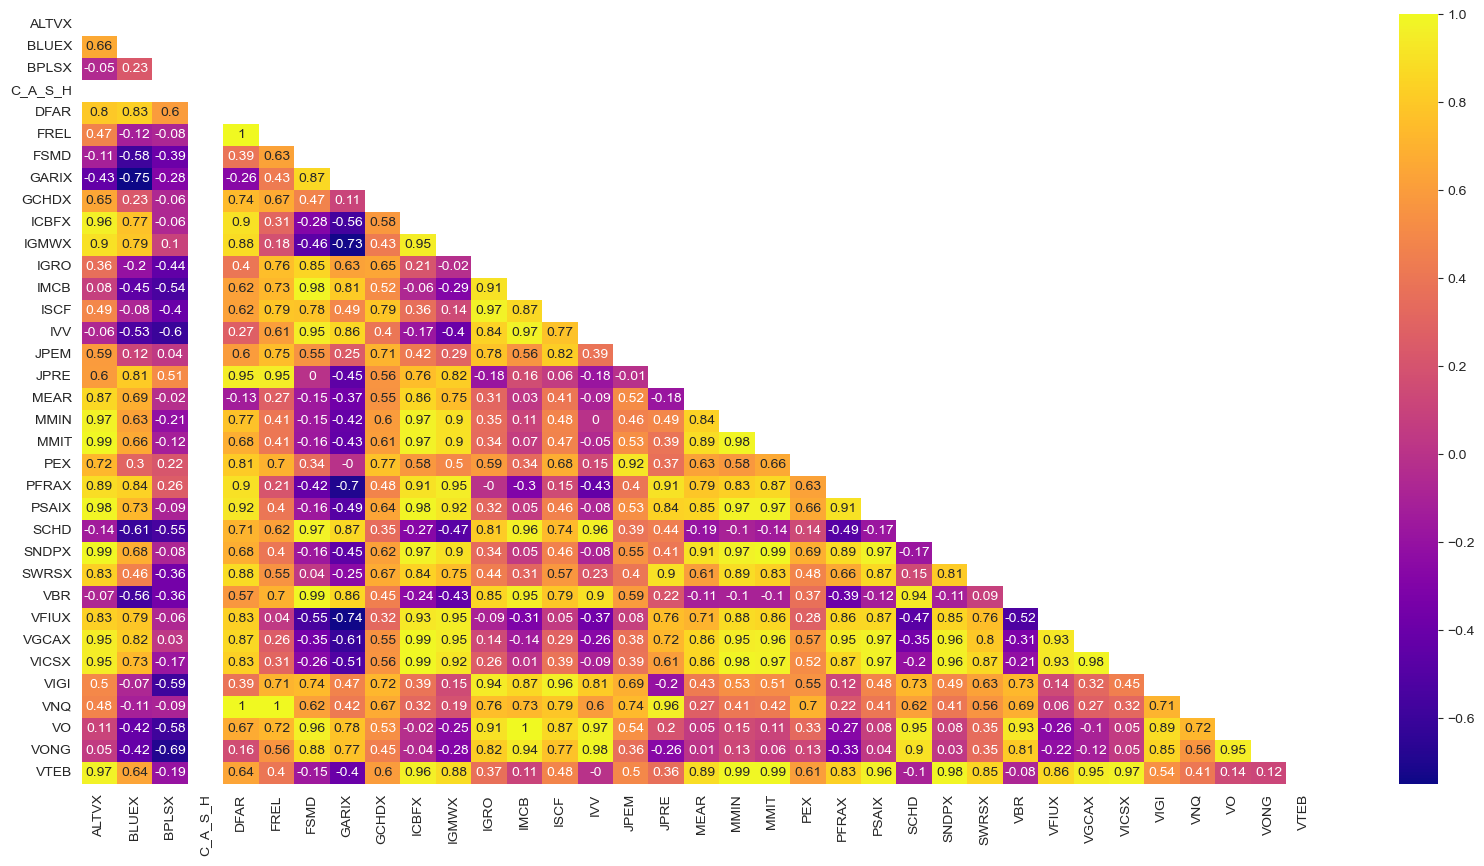

In [114]:
plt.figure(figsize=(20,10))
mask = np.zeros_like(price_df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(price_df.corr().round(2), 
                 annot=True, mask=mask, 
                 cmap="plasma", annot_kws={"size": 10})

# Calculate Portfolio Value

In [115]:
shares_df = folio_df[['Ticker','Shares']]
shares_df.set_index('Ticker', drop=True, inplace=True)
#shares_df[['Shares']].round(0)
shares_df.head()

,Shares
Ticker,
IVV,"8,912.0000"
VONG,"41,501.0000"
SCHD,"41,027.0000"
IMCB,"64,494.0000"
VO,"9,234.0000"


In [116]:
m_df = price_df.copy()
m_df.reset_index(inplace=True)
m_df = m_df.melt(id_vars=['Date'])
m_df.columns = ['Date','Ticker','Price']
m_df.head()

,Date,Ticker,Price
0,2018-10-08,ALTVX,9.9800
1,2018-10-09,ALTVX,9.9600
2,2018-10-10,ALTVX,9.9400
3,2018-10-11,ALTVX,9.9500
4,2018-10-12,ALTVX,9.9500


In [117]:
l_df = folio_df[['Ticker','Class','Sub_Class']] #.drop_duplicates() 
l_df.head()

,Ticker,Class,Sub_Class
0,IVV,Economically Sensitive,U.S. Equities
1,VONG,Economically Sensitive,U.S. Equities
2,SCHD,Economically Sensitive,U.S. Equities
3,IMCB,Economically Sensitive,U.S. Equities
4,VO,Economically Sensitive,U.S. Equities


In [118]:
v_df = volumne_df.copy()
v_df.reset_index(inplace=True)
v_df = v_df.melt(id_vars=['Date'])
v_df.columns = ['Date','Ticker','Volume']
v_df.head()

,Date,Ticker,Volume
0,2018-10-08,ALTVX,0.0000
1,2018-10-09,ALTVX,0.0000
2,2018-10-10,ALTVX,0.0000
3,2018-10-11,ALTVX,0.0000
4,2018-10-12,ALTVX,0.0000


In [119]:
merge_df = m_df.merge(l_df, how='left', left_on='Ticker', right_on='Ticker')     \
                .merge(shares_df,how='left' ,left_on='Ticker', right_on='Ticker') 

merge_df['share_value'] = merge_df['Price'] * merge_df['Shares']
merge_df.head()

,Date,Ticker,Price,Class,Sub_Class,Shares,share_value
0,2018-10-08,ALTVX,9.9800,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,061,702.2913"
1,2018-10-09,ALTVX,9.9600,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,059,574.6841"
2,2018-10-10,ALTVX,9.9400,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,057,446.9754"
3,2018-10-11,ALTVX,9.9500,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,058,510.8297"
4,2018-10-12,ALTVX,9.9500,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,058,510.8297"


In [120]:
merge_df = merge_df.merge(v_df, how='left', left_on=['Ticker','Date'], right_on=['Ticker','Date']) 
merge_df.sort_values(by=['Ticker','Date'], inplace=True)
merge_df

,Date,Ticker,Price,Class,Sub_Class,Shares,share_value,Volume
0,2018-10-08,ALTVX,9.9800,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,061,702.2913",0.0000
1,2018-10-09,ALTVX,9.9600,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,059,574.6841",0.0000
2,2018-10-10,ALTVX,9.9400,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,057,446.9754",0.0000
3,2018-10-11,ALTVX,9.9500,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,058,510.8297",0.0000
4,2018-10-12,ALTVX,9.9500,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,058,510.8297",0.0000
...,...,...,...,...,...,...,...,...
44025,2023-10-02,VTEB,47.7100,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","970,087.4114","17,581,100.0000"
44026,2023-10-03,VTEB,47.5700,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","967,240.8038","15,981,900.0000"
44027,2023-10-04,VTEB,47.7300,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","970,494.0807","11,146,100.0000"
44028,2023-10-05,VTEB,47.7100,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","970,087.4114","10,326,800.0000"


In [121]:
merge_df

,Date,Ticker,Price,Class,Sub_Class,Shares,share_value,Volume
0,2018-10-08,ALTVX,9.9800,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,061,702.2913",0.0000
1,2018-10-09,ALTVX,9.9600,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,059,574.6841",0.0000
2,2018-10-10,ALTVX,9.9400,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,057,446.9754",0.0000
3,2018-10-11,ALTVX,9.9500,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,058,510.8297",0.0000
4,2018-10-12,ALTVX,9.9500,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,058,510.8297",0.0000
...,...,...,...,...,...,...,...,...
44025,2023-10-02,VTEB,47.7100,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","970,087.4114","17,581,100.0000"
44026,2023-10-03,VTEB,47.5700,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","967,240.8038","15,981,900.0000"
44027,2023-10-04,VTEB,47.7300,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","970,494.0807","11,146,100.0000"
44028,2023-10-05,VTEB,47.7100,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","970,087.4114","10,326,800.0000"


In [122]:
#merge_df['Date'] == 

In [123]:
folioValue_df = merge_df.groupby(['Date'])[['share_value']].sum().reset_index()
folioValue_df

,Date,share_value
0,2018-10-08,"70,649,942.9084"
1,2018-10-09,"70,622,211.9340"
2,2018-10-10,"69,786,572.6648"
3,2018-10-11,"69,201,971.4795"
4,2018-10-12,"69,418,381.5503"
...,...,...
1253,2023-10-02,"79,443,848.0453"
1254,2023-10-03,"78,597,476.9912"
1255,2023-10-04,"78,961,375.6978"
1256,2023-10-05,"79,085,850.6373"


In [124]:
a = merge_df[merge_df['Date'] == '2023-09-11']
#.to_csv('./data/tmp.csv', index=False)
#a['share_value'].sum()
a

,Date,Ticker,Price,Class,Sub_Class,Shares,share_value,Volume
1238,2023-09-11,ALTVX,9.4000,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,000,000.1594",0.0000
2496,2023-09-11,BLUEX,35.2100,Economically Sensitive,Long/Short Equities,"14,201.0000","500,017.1970",0.0000
3754,2023-09-11,BPLSX,15.0100,Economically Sensitive,Long/Short Equities,"49,967.0000","750,004.6814",0.0000
5012,2023-09-11,C_A_S_H,1.0000,Cash,Cash,"4,469,000.0000","4,469,000.0000",NaN
6270,2023-09-11,DFAR,20.9600,Economically Sensitive,Publicly Traded REITs,"108,467.0000","2,273,468.2207","109,600.0000"
7528,2023-09-11,FREL,24.4700,Economically Sensitive,Publicly Traded REITs,"115,479.0000","2,825,771.0507","93,700.0000"
8786,2023-09-11,FSMD,33.2600,Economically Sensitive,U.S. Equities,"120,705.0000","4,014,648.0974","6,200.0000"
10044,2023-09-11,GARIX,19.7800,Economically Sensitive,Long/Short Equities,"25,278.0000","499,998.8574",0.0000
11302,2023-09-11,GCHDX,10.8200,Economically Sensitive,Long/Short Equities,"46,211.0000","500,003.0059",0.0000
12560,2023-09-11,ICBFX,6.0100,Interest Rate Sensitive,Very-High-Quality Corporate Bonds,"166,389.0000","999,997.9281",0.0000


In [125]:
folioValue_df[folioValue_df['Date'] == '2023-09-11']

,Date,share_value
1238,2023-09-11,"83,004,840.7077"


In [126]:
folioValue_df[folioValue_df['Date'] == '2023-10-06']

,Date,share_value
1257,2023-10-06,"79,376,544.6729"


In [127]:
folioValue_df['pct_change'] = folioValue_df['share_value'].pct_change()
folioValue_df = folioValue_df[1:]
folioValue_df

,Date,share_value,pct_change
1,2018-10-09,"70,622,211.9340",-0.0004
2,2018-10-10,"69,786,572.6648",-0.0118
3,2018-10-11,"69,201,971.4795",-0.0084
4,2018-10-12,"69,418,381.5503",0.0031
5,2018-10-15,"69,372,196.0426",-0.0007
...,...,...,...
1253,2023-10-02,"79,443,848.0453",-0.0088
1254,2023-10-03,"78,597,476.9912",-0.0107
1255,2023-10-04,"78,961,375.6978",0.0046
1256,2023-10-05,"79,085,850.6373",0.0016


In [128]:
t_df = merge_df.groupby(['Date','Class','Sub_Class'])[['share_value']].sum().reset_index()
t_df

,Date,Class,Sub_Class,share_value
0,2018-10-08,Cash,Cash,"4,469,000.0000"
1,2018-10-08,Economically Sensitive,Emerging Market Equities,"4,121,938.4305"
2,2018-10-08,Economically Sensitive,International Equities,"7,252,601.9388"
3,2018-10-08,Economically Sensitive,Long/Short Equities,"2,768,676.8066"
4,2018-10-08,Economically Sensitive,Private Equity,"5,264,329.4040"
...,...,...,...,...
12575,2023-10-06,Economically Sensitive,Publicly Traded REITs,"9,966,709.3909"
12576,2023-10-06,Economically Sensitive,U.S. Equities,"20,132,642.5854"
12577,2023-10-06,Interest Rate Sensitive,U.S. Government Bonds,"16,478,303.8588"
12578,2023-10-06,Interest Rate Sensitive,Very-High-Quality Corporate Bonds,"4,862,725.4654"


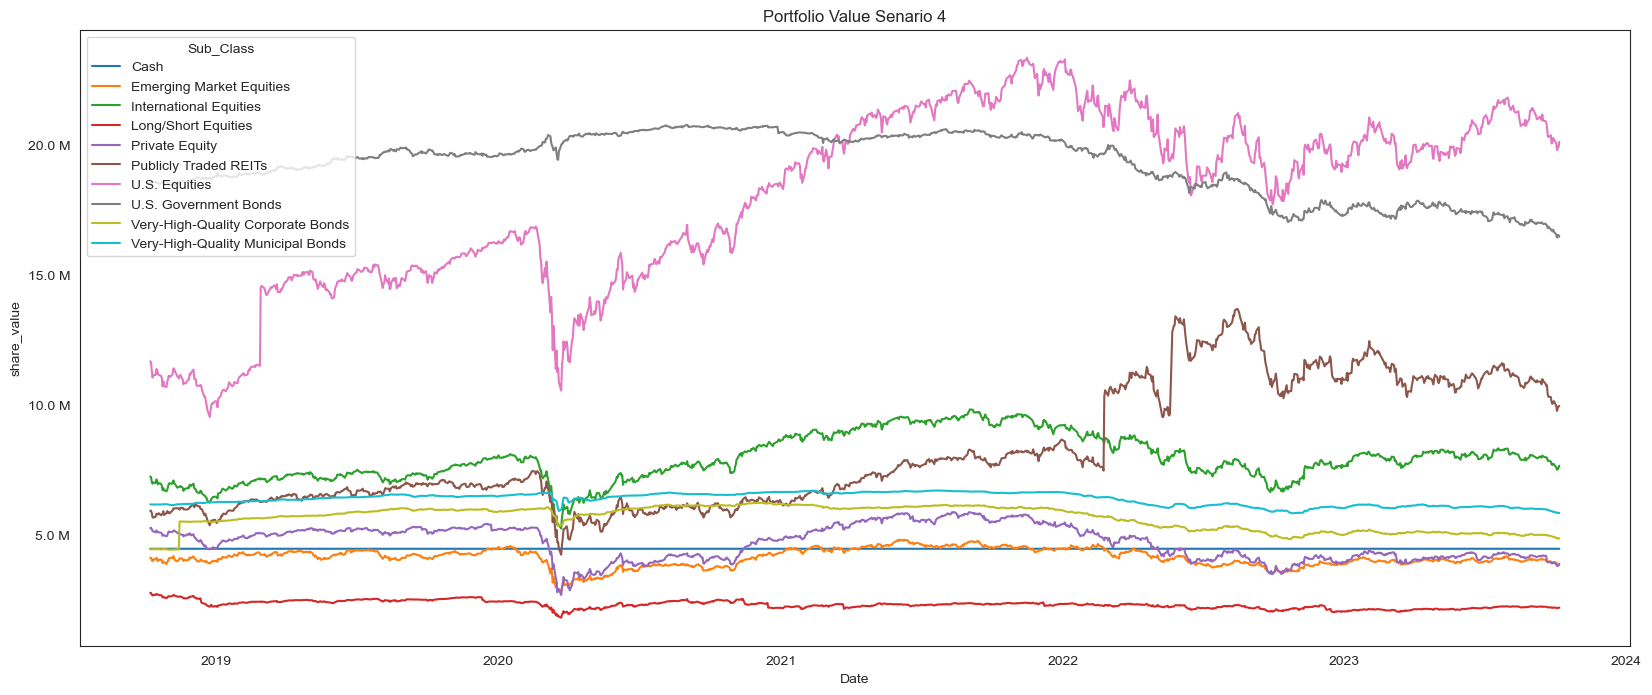

In [129]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
plt.ticklabel_format(style='plain', axis='y')

# Plot
sns.set_style("white")
g = sns.lineplot(data=t_df, x="Date", y="share_value", hue='Sub_Class')
g.set_yticklabels(['{:,.1f}'.format(x) + ' M' for x in g.get_yticks()/1000000])

ax.set(title='Portfolio Value Senario 4');

# Value Weighted Average Price (VWAP)

In [130]:
# Calculate the cumulative total of price times volume
merge_df['Price_Volume'] = merge_df['Price'] * merge_df['Volume']
#merge_df['Cum_Price_Volume'] = merge_df['Price_Volume'].cumsum()
merge_df['Cum_Price_Volume'] = merge_df.groupby('Ticker')['Price_Volume'].transform(pd.Series.cumsum)

# Calculate the cumulative total of volume
merge_df['Cum_Volume'] = merge_df['Volume'].cumsum()
merge_df['Cum_Volume'] = merge_df.groupby('Ticker')['Volume'].transform(pd.Series.cumsum)

# Calculate VWAP
merge_df['VWAP'] = merge_df['Cum_Price_Volume'] / merge_df['Cum_Volume']

In [131]:
merge_df

,Date,Ticker,Price,Class,Sub_Class,Shares,share_value,Volume,Price_Volume,Cum_Price_Volume,Cum_Volume,VWAP
0,2018-10-08,ALTVX,9.9800,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,061,702.2913",0.0000,0.0000,0.0000,0.0000,NaN
1,2018-10-09,ALTVX,9.9600,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,059,574.6841",0.0000,0.0000,0.0000,0.0000,NaN
2,2018-10-10,ALTVX,9.9400,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,057,446.9754",0.0000,0.0000,0.0000,0.0000,NaN
3,2018-10-11,ALTVX,9.9500,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,058,510.8297",0.0000,0.0000,0.0000,0.0000,NaN
4,2018-10-12,ALTVX,9.9500,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,058,510.8297",0.0000,0.0000,0.0000,0.0000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
44025,2023-10-02,VTEB,47.7100,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","970,087.4114","17,581,100.0000","838,794,264.9040","167,876,030,034.1155","3,297,133,900.0000",50.9157
44026,2023-10-03,VTEB,47.5700,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","967,240.8038","15,981,900.0000","760,258,978.1227","168,636,289,012.2383","3,313,115,800.0000",50.8996
44027,2023-10-04,VTEB,47.7300,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","970,494.0807","11,146,100.0000","532,003,347.8977","169,168,292,360.1360","3,324,261,900.0000",50.8890
44028,2023-10-05,VTEB,47.7100,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","970,087.4114","10,326,800.0000","492,691,618.5455","169,660,983,978.6815","3,334,588,700.0000",50.8791


In [134]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44030 entries, 0 to 44029
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              44030 non-null  datetime64[ns]
 1   Ticker            44030 non-null  object        
 2   Price             42142 non-null  float64       
 3   Class             44030 non-null  object        
 4   Sub_Class         44030 non-null  object        
 5   Shares            44030 non-null  float64       
 6   share_value       42142 non-null  float64       
 7   Volume            40884 non-null  float64       
 8   Price_Volume      40884 non-null  float64       
 9   Cum_Price_Volume  40884 non-null  float64       
 10  Cum_Volume        40884 non-null  float64       
 11  VWAP              23279 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(3)
memory usage: 4.0+ MB
